## Question 3

In [0]:
import pandas as pd
import numpy as np
from queue import Queue
import random

In [0]:
class Tree:
    def __init__(self):
        self.left = None
        self.right = None
        self.data = None

In [0]:
#Function to distint Categorical data and Non Categorical data and return a list
def feature_compute(data):
  unique=20
  feature=[]
  for i in data.columns:
    if i!="label":
      uni=data[i].unique()
      ex=uni[0]
      if(isinstance(ex,str) or len(uni)<=unique):
        feature.append("c")
      else:
        feature.append("r")
  return feature

In [0]:
#load data
data = pd.read_csv('/content/drive/My Drive/Datasets.zip (Unzipped Files)/Datasets/q3/train.csv')

#drop unnecessary column who have less tha 500 missing data
data=data.drop(["Id","Alley","PoolQC","MiscFeature","Fence","FireplaceQu"],axis=1)

#change SalePrice to Label
data = data.rename({"SalePrice": "label"}, axis=1)

# distinct Categorical data and Non Categorical data in feature list:
feature=feature_compute(data)

#filling missing data 
    # Categorical data : maximum occurrence
    # Non categorical data : mean of the column
m=0
for i in data.columns:
  if(data[i].isnull().any()==True and i != "label"):
    if(feature[m]=='c'):
      mode_masType = data[i].mode()[0]
      data = data.fillna({i:mode_masType})
    else:
      median_lot = data[i].mean()
      data = data.fillna({i:median_lot})
data=data.replace("C (all)","C(all)")
data_top = data.columns

In [0]:
#Data
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,label
0,60,RL,99.0,12099,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,8,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,388.0,Gd,TA,PConc,Ex,TA,Av,GLQ,970,Unf,0,166,1136,GasA,Ex,Y,SBrkr,1136,1332,0,2468,1,0,2,1,4,1,Gd,10,Typ,1,BuiltIn,2004.0,Fin,3,872,TA,TA,Y,184,154,0,0,0,0,0,6,2007,WD,Normal,354000
1,20,RL,89.0,13214,Pave,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,9,5,2008,2009,Hip,CompShg,Stucco,CmentBd,None,0.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,0,2002,2002,GasA,Ex,Y,SBrkr,2018,0,0,2018,0,0,2,0,3,1,Ex,10,Typ,1,Attchd,2009.0,Fin,3,746,TA,TA,Y,144,76,0,0,0,0,0,5,2010,WD,Normal,378500
2,120,RM,32.0,4500,Pave,Reg,Lvl,AllPub,FR2,Gtl,Mitchel,Norm,Norm,TwnhsE,1Story,6,5,1998,1998,Hip,CompShg,VinylSd,VinylSd,BrkFace,443.0,TA,Gd,PConc,Ex,Gd,No,GLQ,1201,Unf,0,36,1237,GasA,Ex,Y,SBrkr,1337,0,0,1337,1,0,2,0,2,1,TA,5,Typ,0,Attchd,1998.0,Fin,2,405,TA,TA,Y,0,199,0,0,0,0,0,3,2006,WD,Normal,153500
3,160,FV,30.0,3000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,6,5,2009,2009,Gable,CompShg,VinylSd,VinylSd,Stone,76.0,Gd,TA,PConc,Gd,TA,Av,GLQ,294,Unf,0,318,612,GasA,Ex,Y,SBrkr,612,612,0,1224,0,0,2,1,2,1,Gd,4,Typ,0,Detchd,2009.0,RFn,2,528,TA,TA,Y,0,234,0,0,0,0,0,6,2009,New,Partial,173733
4,20,RL,60.0,6897,Pave,IR1,Lvl,AllPub,Corner,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1962,2010,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,CBlock,TA,TA,No,ALQ,659,Unf,0,381,1040,GasA,Ex,Y,SBrkr,1040,0,0,1040,1,0,1,1,3,1,TA,6,Typ,0,Detchd,1962.0,Unf,1,260,TA,TA,Y,0,104,0,0,0,0,0,4,2010,WD,Normal,127000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,120,RL,40.0,6792,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,Stone,94.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1368,1368,GasA,Ex,Y,SBrkr,1368,0,0,1368,0,0,2,0,2,1,Gd,6,Typ,1,Attchd,2005.0,RFn,2,474,TA,TA,Y,132,35,0,0,0,0,0,3,2006,New,Partial,202665
996,30,RL,85.0,10625,Pave,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,ALQ,108,Unf,0,350,458,GasA,Fa,N,SBrkr,835,0,0,835,0,0,1,0,2,1,TA,5,Typ,0,Basment,1920.0,Unf,1,366,Fa,TA,Y,0,0,77,0,0,0,400,5,2010,COD,Abnorml,83000
997,85,RL,60.0,9101,Pave,IR1,Lvl,AllPub,Corner,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,6,1978,1978,Gable,CompShg,Plywood,Plywood,BrkFace,104.0,TA,Gd,PConc,Gd,TA,Av,GLQ,1097,Unf,0,0,1097,GasA,Ex,Y,SBrkr,1110,0,0,1110,1,0,1,0,1,1,Gd,4,Typ,1,Attchd,1978.0,Fin,2,602,TA,TA,Y,303,30,0,0,0,0,0,7,2009,WD,Normal,165500
998,20,RL,75.0,13125,Pave,Reg,Lvl,AllPub,Inside,Mod,CollgCr,Norm,Norm,1Fam,1Story,6,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,215.0,TA,TA,PConc,Gd,TA,Gd,GLQ,994,Unf,0,484,1478,GasA,Ex,Y,SBrkr,1493,0,0,1493,1,0,2,0,3,1,Gd,7,Typ,1,Attchd,1997.0,Fin,2,508,TA,TA,Y,140,39,0,0,0,0,0,4,2008,WD,Normal,208900


In [0]:
#all missing column fill by respective value
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 75 columns):
MSSubClass       1000 non-null int64
MSZoning         1000 non-null object
LotFrontage      1000 non-null float64
LotArea          1000 non-null int64
Street           1000 non-null object
LotShape         1000 non-null object
LandContour      1000 non-null object
Utilities        1000 non-null object
LotConfig        1000 non-null object
LandSlope        1000 non-null object
Neighborhood     1000 non-null object
Condition1       1000 non-null object
Condition2       1000 non-null object
BldgType         1000 non-null object
HouseStyle       1000 non-null object
OverallQual      1000 non-null int64
OverallCond      1000 non-null int64
YearBuilt        1000 non-null int64
YearRemodAdd     1000 non-null int64
RoofStyle        1000 non-null object
RoofMatl         1000 non-null object
Exterior1st      1000 non-null object
Exterior2nd      1000 non-null object
MasVnrType       1000 non

In [0]:
# Splitting data into train and validation randomly

def train_test_split(data,test_size):
  if(isinstance(test_size,float)):
    test_size=round(test_size*len(data))
  i = data.index.tolist()
  test_indices = random.sample(population=i, k=test_size)
  test_df = data.loc[test_indices]
  train_df = data.drop(test_indices)
  return train_df,test_df

In [0]:
train_d,test_d = train_test_split(data,0.1)

In [0]:
print("Total Data Size= ",len(data),"\nTrain Size= ",len(train_d),"\nValidation Size= ",len(test_d))

Total Data Size=  1000 
Train Size=  900 
Validation Size=  100


## Function to find potential split, Entropy, Mean Square Error, Mean Absolute Error

In [0]:
#Compute potential split

def get_split(data):
  d={}
  _,col=data.shape
  for i in range(0,col-1):
    val=data[:,i]
    val=np.unique(val)
    if(feature[i]=='c'):
      d[i]=val
    else:
      value=[]
      val=sorted(val)
      for j in range(1,len(val)):
        value.append((val[j]+val[j-1])/2)
      d[i]=value
  return d


In [0]:
# Split data into 2 part low and high 

def data_split(data,col,val):
  col_val=data[:,col]
  if(feature[col]=='c'):
    low=data[col_val==val]
    high=data[col_val!=val]
  else:
    low=data[col_val<=val]
    high=data[col_val>val]
  return low,high

In [0]:
#Compute Mean Square Error

def mse(data):
  label=data[:,-1]
  if(len(label)==0):
    mse=0
  else:
    p=np.mean(label)
    mse=np.mean((label-p)**2)
  return mse

In [0]:
#Compute Mean Absolute Error

def mae(data):
  label=data[:,-1]
  if(len(label)==0):
    mse=0
  else:
    p=np.mean(label)
    mse=np.mean(abs(label-p))
  return mse

In [0]:
#Compute Entropy 
    #formula : probability(low)* Mean_square_error(low) + probability(high)* Mean_square_error(high)

def getEntropy(low,high,fun):
  l=len(low)+len(high)
  p_low=len(low)/l
  p_high=len(high)/l
  if fun=="mse":
      total=(p_low*mse(low)+ p_high*mse(high))
  else:
      total=(p_low*mae(low)+ p_high*mae(high)) 
  return total

In [0]:
# Find data value and column where it have minimum entropy 

def best_split(data,ind,fun):
  k = True
  for i in ind:
      for j in ind[i]:
        low,high=data_split(data,i,j)
        c_m=getEntropy(low,high,fun)
        if(k==True or c_m<b_m):
          b_m=c_m
          col=i
          val=j
          k=False
  return col,val

# DecisionTree Algo

In [0]:
def DecisionTree(data,root,fun,maxdepth=15,counter=0):
  root =Tree()
  if(len(data)<=20 or counter >maxdepth) :
    label=data[:,-1]
    root.data=np.mean(label)
    root.left=None
    root.right=None
    return root
  counter=counter+1
  ind=get_split(data)
  col,val=best_split(data,ind,fun)
  low,high=data_split(data,col,val)
  if(len(low)==0 or len(high)==0):
    label=data[:,-1]
    root.data=np.mean(label)
    root.left=None
    root.right=None
    return root
  if(feature[col]=='r'):
    root.data = "{} <= {}".format(data_top[col],val)
  else:
    root.data = "{} = {}".format(data_top[col],val)
  first = DecisionTree(low,root.left,maxdepth,counter)
  second = DecisionTree(high,root.right,maxdepth,counter)
  if first == second:
      root.left = first
      root.right=None
  else:
      root.left= first
      root.right =second   
  return root


In [0]:
root=0
tree=DecisionTree(train_d.values,root,"mse")
tree2=DecisionTree(train_d.values,root,"mae")

In [0]:
def predict(tree,test):
  temp=tree
  if(isinstance(temp.data,float)):
    return temp.data
  if(len(temp.data.split(" "))==4):
    fet,op,val,val2 = temp.data.split(" ")
    val=val+val2
  else:  
    fet,op,val = temp.data.split(" ")
  if(op == "="):
    if(test[fet] == val):
      return predict(tree.left,test)
    return predict(tree.right,test)
  else:
    if(test[fet] <= float(val)):
      return predict(tree.left,test)
  return predict(tree.right,test)

In [0]:
# By mean square error
sum=0
for i in range(len(test_d)):
    x=predict(tree,test_d.iloc[i])
    sum+=abs(x-test_d.values[i][74])
print("Error Rate= ",sum)

Error Rate=  3485326.1641435414


In [0]:
# By mean absolute error
sum=0
for i in range(len(test_d)):
    x=predict(tree2,test_d.iloc[i])
    sum+=abs(x-test_d.values[i][74])
print("Error Rate= ",sum)

Error Rate=  3580516.652025424


In [0]:
test_d = pd.read_csv('/content/drive/My Drive/Datasets.zip (Unzipped Files)/Datasets/q3/test.csv')
test_l = pd.read_csv('/content/drive/My Drive/Datasets.zip (Unzipped Files)/Datasets/q3/test_labels.csv',header=None)
#drop unnecessary column who have less tha 500 missing data
test_d=test_d.drop(["Id","Alley","PoolQC","MiscFeature","Fence","FireplaceQu"],axis=1)

# distinct Categorical data and Non Categorical data in feature list:
feature=feature_compute(test_d)

#filling missing data 
    # Categorical data : maximum occurrence
    # Non categorical data : mean of the column
m=0
for i in test_d.columns:
  if(test_d[i].isnull().any()==True):
    if(feature[m]=='c'):
      mode_masType = test_d[i].mode()[0]
      test_d = test_d.fillna({i:mode_masType})
    else:
      median_lot = test_d[i].mean()
      test_d = test_d.fillna({i:median_lot})
test_d=test_d.replace("C (all)","C(all)")

In [0]:
#Load Test Data
train_d=data
root=0
tree=DecisionTree(train_d.values,root,"mse")
tree2=DecisionTree(train_d.values,root,"mae")

In [0]:
pre=[]
for i in range(len(test_d)):
    pre.append(predict(tree,test_d.iloc[i]))
act=[]
for i in range(len(test_l)):
    act.append(test_l.iloc[i][1])

In [0]:
from sklearn.metrics import r2_score
r2_score(act, pre)

0.5043276343023568

In [0]:
from sklearn.metrics import mean_squared_error
mean_squared_error(act,pre)

2619531813.089953

In [0]:
pre=[]
for i in range(len(test_d)):
    pre.append(predict(tree2,test_d.iloc[i]))
act=[]
for i in range(len(test_l)):
    act.append(test_l.iloc[i][1])

In [0]:
from sklearn.metrics import r2_score
r2_score(act, pre)

0.6678722554809082

In [0]:
from sklearn.metrics import mean_squared_error
mean_squared_error(act,pre)

1755230375.9219034

No handles with labels found to put in legend.


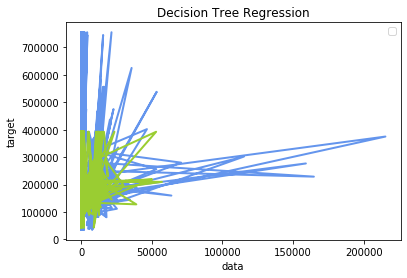

In [43]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(data.values,y.values, color="cornflowerblue",linewidth=2)
plt.plot(data2.values,pre,color="yellowgreen", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [33]:
#By sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
# data=n
k=0
y=data['label']
data=data.drop(["label"],axis=1)
y.values
for i in data.columns:
  if(feature[k]=='c'):
    jobs_encoder = LabelEncoder()
    jobs_encoder.fit(data[i])
    transformed = jobs_encoder.transform(data[i])
    ohe_df = pd.DataFrame(transformed)
    data = pd.concat([data, ohe_df], axis=1).drop([i], axis=1)
  k=k+1
data.values
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_1.fit(data.values,y.values)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
k=0
data2=test_d
for i in data2.columns:
  if(feature[k]=='c'):
    jobs_encoder = LabelEncoder()
    jobs_encoder.fit(data2[i])
    transformed = jobs_encoder.transform(data2[i])
    ohe_df = pd.DataFrame(transformed)
    data2 = pd.concat([data2, ohe_df], axis=1).drop([i], axis=1)
  k=k+1
yy=regr_1.predict(data2.values)

In [0]:
from sklearn.metrics import r2_score
r2_score(test_l.values[:,-1], yy)

0.41763448853246976

In [0]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_l.values[:,-1], yy)

3077688186.2043476

No handles with labels found to put in legend.


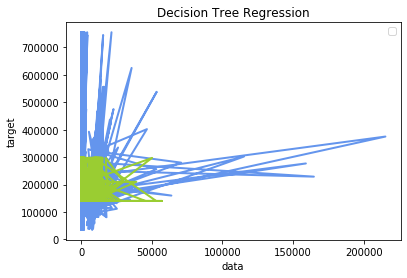

In [41]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(data.values,y, color="cornflowerblue",linewidth=2)
plt.plot(data2.values,yy, color="yellowgreen", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()
